In [1]:
import numpy as np
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

from pymir import pd_utils

import matplotlib
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import metrics as sk_metrics

In [2]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_finemap"

In [3]:
# db = os.path.join(dsc_output, os.path.basename(os.path.normpath(dsc_output)) + ".db")
db = os.path.join(dsc_output, "linreg_finemap.db")
print(db)

/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_finemap/linreg_finemap.db


In [4]:
'''
Target can be any module name, group name
or module.variable
There are two groups of methods, one of them 
needs to be force removed during query (groups = ["fit_cpt:"])
'''

target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [5]:
qp = dscQP(db, target, condition)
qp_df = qp.output_table
qp_df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file
0,1,blockdiag,20,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",susie,susie/blockdiag_1_susie_1
1,2,blockdiag,20,blockdiag/blockdiag_2,0.6,blockdiag/blockdiag_2,"(500,10000)",susie,susie/blockdiag_2_susie_1
2,3,blockdiag,20,blockdiag/blockdiag_3,0.6,blockdiag/blockdiag_3,"(500,10000)",susie,susie/blockdiag_3_susie_1
3,4,blockdiag,20,blockdiag/blockdiag_4,0.6,blockdiag/blockdiag_4,"(500,10000)",susie,susie/blockdiag_4_susie_1
4,5,blockdiag,20,blockdiag/blockdiag_5,0.6,blockdiag/blockdiag_5,"(500,10000)",susie,susie/blockdiag_5_susie_1
5,1,blockdiag,20,blockdiag/blockdiag_1,0.6,blockdiag/blockdiag_1,"(500,10000)",mr_ash,mr_ash/blockdiag_1_mr_ash_1
6,2,blockdiag,20,blockdiag/blockdiag_2,0.6,blockdiag/blockdiag_2,"(500,10000)",mr_ash,mr_ash/blockdiag_2_mr_ash_1
7,3,blockdiag,20,blockdiag/blockdiag_3,0.6,blockdiag/blockdiag_3,"(500,10000)",mr_ash,mr_ash/blockdiag_3_mr_ash_1
8,4,blockdiag,20,blockdiag/blockdiag_4,0.6,blockdiag/blockdiag_4,"(500,10000)",mr_ash,mr_ash/blockdiag_4_mr_ash_1
9,5,blockdiag,20,blockdiag/blockdiag_5,0.6,blockdiag/blockdiag_5,"(500,10000)",mr_ash,mr_ash/blockdiag_5_mr_ash_1


In [21]:
def stratify_dfcol(df, colname, value):
    return df.loc[df[colname] == value]

def binarize(b):
    bb = np.zeros_like(b)
    bb[ b != 0 ] = 1
    return bb

def read_dsc_data(df, idsc):
    dfm = stratify_dfcol(df, 'DSC', idsc)
    fprefix = dfm['simulate.output.file'].values[0]
    fname = os.path.join(dsc_output, f"{fprefix}.pkl")
    data = dsc_io.load_dsc(fname)
    return data

def read_pip(df, method, idsc):
    dfm = stratify_dfcol(df, 'DSC', idsc)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'rds'
    if method in ['gradvi_direct', 'gradvi_compound']:
        ext = 'pkl'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data['pip']
    

def read_result(df, method):
    dfm = stratify_dfcol(df, 'fit', method)
    res = []
    for idsc in dfm['DSC'].values:
        btrue = binarize(read_dsc_data(dfm, idsc)['beta'])
        bpred = read_pip(dfm, method, idsc)
        res.append((btrue, bpred))
    return res


def precision_recall_interp_mean(data, ninterp = 1000):
    '''
    data : list of (ytrue, ypred) for n simulations
    '''
    x = np.logspace(-5, 0, ninterp - 1)
    x = np.insert(x, 0, 0.)
    y = np.zeros(ninterp)
    for i, d in enumerate(data):
        precision, recall, thresholds = sk_metrics.precision_recall_curve(d[0], d[1])
        ysim  = np.interp(x, precision, recall)
        y += ysim
    y /= len(data)
    return x, y

In [22]:
susie = read_result(qp_df, 'susie')
gradvi = read_result(qp_df, 'gradvi_compound')
gradvi_direct = read_result(qp_df, 'gradvi_direct')

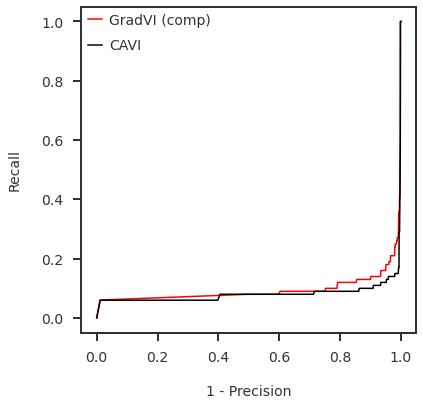

In [30]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)

# precision, recall = precision_recall_interp_mean(susie, ninterp = 1000)
# ax1.plot(1 - precision, recall, label = "Susie", color = "blue")

precision, recall = precision_recall_interp_mean(gradvi, ninterp = 1000)
ax1.plot(1 - precision, recall, label = "GradVI (comp)", color = "red")

precision, recall = precision_recall_interp_mean(gradvi_direct, ninterp = 1000)
ax1.plot(1 - precision, recall, label = "CAVI", color = "black")

ax1.legend()

ax1.set_xlabel("1 - Precision")
ax1.set_ylabel("Recall")

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)
fig.savefig("variable_selection_gradvi_cavi.pdf", bbox_inches = 'tight')

plt.show()

In [9]:
'''
def plot_fdr_recall(ax, btrue, bpred, label, color):
    precision, recall, thresholds = sk_metrics.precision_recall_curve(btrue, bpred)
    ax.plot(1 - precision, recall, label = label, color = color)
    return

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#for x in susie:
#    plot_fdr_recall(ax1, x[0], x[1], 'Susie', 'blue')
plot_fdr_recall(ax1, 
                np.concatenate([x[0] for x in susie]),
                np.concatenate([x[1] for x in susie]),
                'Susie', 'blue'
               )

plot_fdr_recall(ax1, 
                np.concatenate([x[0] for x in gradvi]),
                np.concatenate([x[1] for x in gradvi]),
                'GradVI', 'red'
               )

for x in gradvi:
    plot_fdr_recall(ax2, x[0], x[1], 'Mr.Ash', 'red')
#mpl_utils.plot_diag(ax1)
ax1.legend()
plt.show()
'''

"\ndef plot_fdr_recall(ax, btrue, bpred, label, color):\n    precision, recall, thresholds = sk_metrics.precision_recall_curve(btrue, bpred)\n    ax.plot(1 - precision, recall, label = label, color = color)\n    return\n\nfig = plt.figure(figsize = (12, 6))\nax1 = fig.add_subplot(121)\nax2 = fig.add_subplot(122)\n#for x in susie:\n#    plot_fdr_recall(ax1, x[0], x[1], 'Susie', 'blue')\nplot_fdr_recall(ax1, \n                np.concatenate([x[0] for x in susie]),\n                np.concatenate([x[1] for x in susie]),\n                'Susie', 'blue'\n               )\n\nplot_fdr_recall(ax1, \n                np.concatenate([x[0] for x in gradvi]),\n                np.concatenate([x[1] for x in gradvi]),\n                'GradVI', 'red'\n               )\n\nfor x in gradvi:\n    plot_fdr_recall(ax2, x[0], x[1], 'Mr.Ash', 'red')\n#mpl_utils.plot_diag(ax1)\nax1.legend()\nplt.show()\n"